# Pytorch Text - Translation With A Sqeuence To Sequence Network and Attention
Notebook for following along with Pytorch Text NLP From Scratch tutorials that is looking at creating a NN to translate French to English [Pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cpu. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
                read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs    
    
print("\nData sets successfully imported.")


Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cpu


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>Lang - Language encoder that converts words into a single hot-vector.</li>
    <li>Encoder - Outputs some value for every word from the input sentence. For every input word the encord outputs a vector and a hidden state, which is used for the next input word.</li>
    <li>Decoder - takes the encoder output vector(s) and outputs a sequence of words to create the translation.</li>
</ul>

In [6]:
#Constants
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

In [7]:
#Class definition cell
class Lang:
    def __init__(self, name) -> None:
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1:"EOS"}
        self.n_words = 2 #Count SOS and EOS
        return None
        
    def addSentence(self, sentence) -> None:
        for word in sentence.split(' '):
            self.addWord(word)
        return None
    
    def addWord(self, word) -> None:
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        return None

    
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        return None
    
    def forward(self, input, hidden):
        embedding = self.embedding(input).view(1, 1, -1)
        output = embedding
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size) -> None:
        super(DecoderRNN, self).init()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        return None
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        ebeded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>filterPair - Checks if the data is below the length of MAX_LENGTH</li>
    <li>filterPairs - returns elements in a list if below the MAX_LENGTH</li>
    <li>prepareData - filters data by MAX_LENGTH, printing relevant information</li>
</ul>

In [8]:
#Calculation functions cell
def filterPair(p) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs\n" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs\n" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words, "\n")
    return input_lang, output_lang, pairs
    
print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li>evaluateAndShowAttention - runs input sentence through NLP model and calls showAttention to display attention matrix</li>
    <li>showAttention - displays attention matrix for input sentence</li>
    <li>showPlot - plots input array, used for plot_losses</li>
</ul>

In [31]:
#Plotting functions Cell
#plt.switch_backend('agg')
%matplotlib inline

def evaluateAndShowAttention(input_sentence) -> None:
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    return None

def showAttention(input_sentence, output_words, attentions) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+input_sentence.split(' ')+['<EOS>'], rotation=90)
    ax.set_yticklabels(['']+output_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    return None

def showPlot(points) -> None:
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title("Average Training Loss")
    plt.ylabel("Average Loss Value")
    plt.xlabel("Loss Check Point")
    return None
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code

In [10]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

In [11]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs

Trimmed to 10599 sentence pairs

Counting words...
Counted words:
fra 4345
eng 2803 

['tu n es pas notre ami .', 'you are not our friend .']


#### Training Functions

In [12]:
#Training Preparation Functions
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang,pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def asMinutes(s):
    return '%dm %ds' % (s//60, s%60)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s/percent
    rs = es - s
    return '%s (est: %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
#Single training function
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
                                        input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device = device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random()<teacher_forcing_ratio else False
    
    if use_teacher_forcing: #Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = target_tensor[di]
            loss += criterion(decoder_output, target_tensor[di])
    else: #Without teacher forcing: use own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() #detatch from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item()==EOS_token: break
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length

In [14]:
#Main training loop function
def trainIters(encoder, decoder, n_iters, print_every=1000, 
               plot_every=1000, learning_rate=0.01) -> [int]:
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) 
                         for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter%print_every==0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print('Duration %s (%d %d%%) %.4f' % 
                  (timeSince(start, iter/n_iters), iter, 
                   iter/n_iters *100, print_loss_avg))
            
        if iter%plot_every==0:
            plot_losses.append(plot_loss_total/plot_every)
            plot_loss_total = 0
            
    showPlot(plot_losses)
    return plot_losses

#### Evaluating Functions

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di+1]

    
def evaluateRandomly(encoder, decoder, n=10) -> None:
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    return None

#### Training and Evaluating

Duration 4m 44s (est: 66m 16s) (5000 6%) 2.8225
Duration 8m 57s (est: 58m 11s) (10000 13%) 2.2938
Duration 12m 52s (est: 51m 28s) (15000 20%) 1.9725
Duration 16m 47s (est: 46m 10s) (20000 26%) 1.7423
Duration 20m 54s (est: 41m 48s) (25000 33%) 1.5344
Duration 24m 29s (est: 36m 43s) (30000 40%) 1.3761
Duration 28m 24s (est: 32m 28s) (35000 46%) 1.2600
Duration 32m 14s (est: 28m 12s) (40000 53%) 1.1137
Duration 36m 12s (est: 24m 8s) (45000 60%) 0.9894
Duration 40m 9s (est: 20m 4s) (50000 66%) 0.8933
Duration 44m 5s (est: 16m 1s) (55000 73%) 0.7981
Duration 48m 3s (est: 12m 0s) (60000 80%) 0.7228
Duration 52m 0s (est: 8m 0s) (65000 86%) 0.6600
Duration 55m 57s (est: 3m 59s) (70000 93%) 0.6083
Duration 59m 53s (est: 0m 0s) (75000 100%) 0.5811


<Figure size 640x480 with 0 Axes>

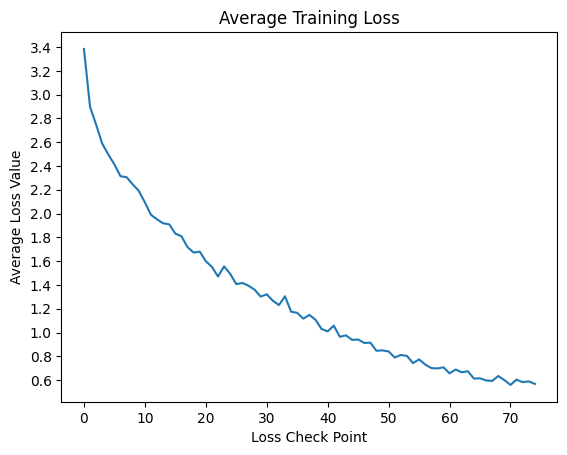

In [16]:
teacher_forcing_ratio = 0.5 #Freq real target outputs are used as next input
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               dropout_p=0.1).to(device)
#trainIters(encoder1, attn_decoder1, 100, print_every=20) #short training
model1Losses = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [17]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis contre le travail du dimanche .
= i am against working on sundays .
< i am against working on sundays . <EOS>

> je me fais trop vieux pour ce travail .
= i m getting too old for this job .
< i m getting too old for this job . <EOS>

> tu es le professeur .
= you re the teacher .
< you re the teacher . <EOS>

> vous etes endurante .
= you re resilient .
< you re resilient . <EOS>

> personne n est trop vieux pour apprendre .
= you re never too old to learn .
< you re too old to learn . <EOS>

> il est dj .
= he is a dj .
< he is a . . <EOS>

> je suis tres impressionnee .
= i m definitely impressed .
< i m very impressed . <EOS>

> je ne suis vraiment pas occupe .
= i m really not busy .
< i m really really . . <EOS>

> nous sommes engages .
= we re committed .
< we re starved . <EOS>

> je suis un etranger .
= i m a foreigner .
< i am a foreigner . <EOS>



### Visualizing Attention

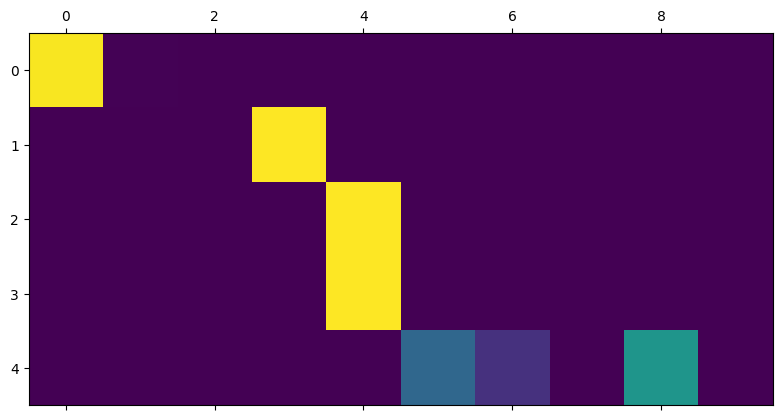

In [18]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, 'je suis trop froid .')
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than i am . <EOS>


C:\Users\ellaw\AppData\Local\Temp\ipykernel_27492\1933310863.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+input_sentence.split(' ')+['<EOS>'], rotation=90)
C:\Users\ellaw\AppData\Local\Temp\ipykernel_27492\1933310863.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+output_words)


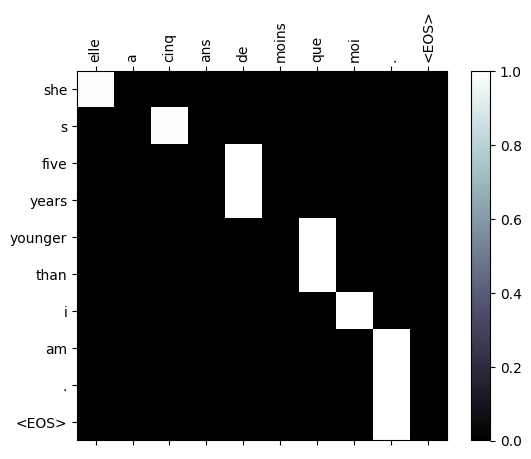

input = elle est trop petit .
output = she is too loud . <EOS>


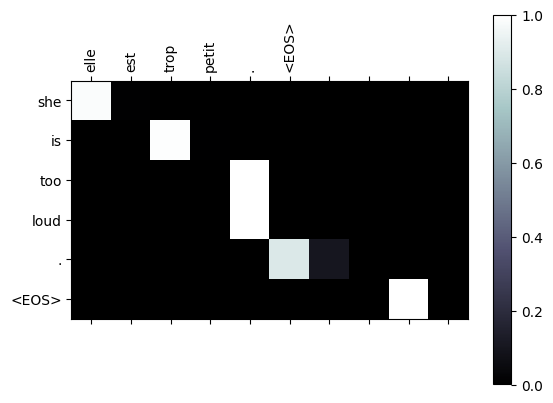

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


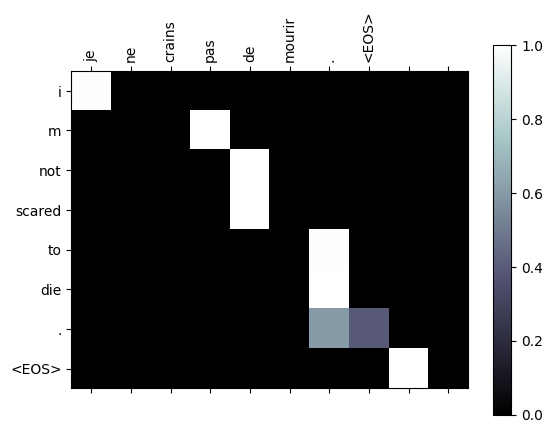

input = c est un jeune directeur plein de talent .
output = he s a very young man . . <EOS>


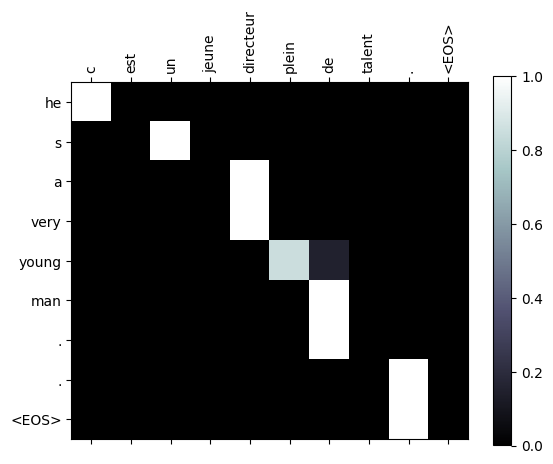

In [32]:
#Evaluation matrix for test input sentences
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

### Exporting Language Models

In [22]:
with open(f'{input_lang.name}_index2word.txt', 'w') as f:
    f.write(str(input_lang.index2word))
    f.close()
    
with open(f'{output_lang.name}_index2word.txt', 'w') as f:
    f.write(str(output_lang.index2word))
    f.close()

print(f"Input language ({input_lang.name}) and output language ({output_lang.name}) models exported as {input_lang.name}_index2word.txt and {output_lang.name}_index2word.txt")

Input language (fra) and output language (eng) models exported as fra_index2word.txt and eng_index2word.txt


### Exporting the Encoder and Decoder

In [23]:
print(encoder1.eval())
print(attn_decoder1.eval())

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)


In [24]:
with open(f'{input_lang.name}_{output_lang.name}_meta.txt', 'w') as f:
    f.write(f'hidden_size: {hidden_size}\n')
    f.write(f'input_lang.n_words: {input_lang.n_words}\n')
    f.write(f'output_lang.n_words: {output_lang.n_words}\n')
    f.write(f'Attn_additional: dropout_p={0.1}\n')
    f.close()

In [25]:
torch.save(encoder1.state_dict(), 
           f'encoder_{input_lang.name}_{output_lang.name}_weights.pth')
torch.save(attn_decoder1.state_dict(), 
           f'attn_decoder_{input_lang.name}_{output_lang.name}_weights.pth')
print("Encoder and Attention Decoder weights saved.")

Encoder and Attention Decoder weights saved.


### Reloading the Model

In [26]:
encoderReload = EncoderRNN(input_lang.n_words, hidden_size)
encoderReload.load_state_dict(torch.load(f'encoder_{input_lang.name}_{output_lang.name}_weights.pth'))
encoderReload.eval()

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

In [27]:
attn_decoderReload = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               dropout_p=0.1)
attn_decoderReload.load_state_dict(torch.load(f'attn_decoder_{input_lang.name}_{output_lang.name}_weights.pth'))
attn_decoderReload.eval()

AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)

### Reload Test

In [28]:
evaluateRandomly(encoderReload, attn_decoderReload)

> il est habile aux jeux video .
= he s skilled at videogames .
< he s skilled at videogames . <EOS>

> nous sommes en train de jouer aux cartes .
= we re playing cards .
< we re playing cards . <EOS>

> il est malpoli .
= he is a rude person .
< he is a southpaw . <EOS>

> nous sommes tres proches .
= we re very close .
< we re very close . <EOS>

> il n est qu un reveur .
= he is nothing more than a dreamer .
< he is nothing more than a dreamer . <EOS>

> je suis etonne de te voir .
= i m surprised to see you .
< i m surprised to see you . <EOS>

> vous ne comptez pas au nombre des suspects .
= you re not a suspect .
< you re not a . . <EOS>

> je suis vannee .
= i am exhausted .
< i am exhausted . <EOS>

> je ne suis certainement pas ton amie .
= i m certainly not your friend .
< i m certainly at friend friend . <EOS>

> nous sommes en train de lire .
= we re reading .
< we re reading . <EOS>



<br>